In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm.auto import tqdm
from xgboost import XGBClassifier

from automated_scoring.config import cfg
from automated_scoring.io import load_dataset, save_dataset
from automated_scoring.features import DataFrameFeatureExtractor
from automated_scoring.classification.predict import predict_dataset
from automated_scoring.classification.visualization import (
    plot_confusion_matrix,
    plot_classification_timeline,
)

from sklearn.utils.class_weight import compute_sample_weight
from scipy.signal import medfilt

cfg.key_keypoints = "keypoints"
cfg.key_timestamp = "timestamps"

cfg.trajectory_keys = (
    "keypoints",
    "timestamps",
)

In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
dataset_train = load_dataset("mice_train", directory="datasets", target="dyads")
dataset_test = load_dataset("mice_test", directory="datasets", target="dyads")

Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.
Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.


In [4]:
extractor = DataFrameFeatureExtractor(cache_directory="feature_cache_mice").read_yaml("config_file.yaml")

In [5]:
def subsample_train(
    dataset,
    extractor,
    random_state=None,
    exclude=None,
):
    X_subsample_even, y_subsample_even = dataset.subsample(
        extractor,
        0.1,
        categories=("none", "investigation"),
        random_state=random_state,
        show_progress=False,
        exclude=exclude,
    )
    X_subsample_all, y_subsample_all = dataset.subsample(
        extractor,
        1.0,
        try_even_subsampling=False,
        categories=("attack", "mount"),
        random_state=random_state,
        show_progress=False,
        exclude=exclude,
    )
    return (
        pd.concat([X_subsample_even, X_subsample_all]),
        np.concatenate([y_subsample_even, y_subsample_all]),
    )

In [6]:
# _, categories = subsample_train(dataset_train, extractor, exclude=[('intruder', 'resident')])
# unique_categories, counts = np.unique(categories, return_counts=True)

# print(unique_categories)
# print(counts, counts / counts.sum())

# counts = []

# for group_key in dataset_train.group_keys:
#     group = dataset_train.select(group_key)
#     for key in group.keys:
#         if key == ('intruder', 'resident'):
#             continue
#         dyad = group.select(key)
#         counts.append([dyad.category_idx(category).size for category in np.unique(unique_categories)])

# counts = np.asarray(counts)
# print(counts.sum(axis=0), counts.sum(axis=0) / counts.sum())

# counts = []

# for group_key in dataset_test.group_keys:
#     group = dataset_test.select(group_key)
#     for key in group.keys:
#         if key == ('intruder', 'resident'):
#             continue
#         dyad = group.select(key)
#         counts.append([dyad.category_idx(category).size for category in np.unique(unique_categories)])

# counts = np.asarray(counts)
# print(counts.sum(axis=0), counts.sum(axis=0) / counts.sum())

In [7]:
from automated_scoring.utils import ensure_generator

In [8]:
num_iterations = 20

scores_timestamp = []
scores_annotation = []
scores_prediction = []

confusion_timestamp = []
confusion_annotation = []
confusion_prediction = []

for iteration in tqdm(range(1, 1 + num_iterations)):
    random_state = ensure_generator(iteration)

    # training pipeline
    X, y = subsample_train(dataset_train, extractor, exclude=[('intruder', 'resident')], random_state=random_state)
    y = dataset_train.encode(y)
    classifier = XGBClassifier(n_estimators=1000, random_state=random_state).fit(X.to_numpy(), y, sample_weight=compute_sample_weight('balanced', y))
    test_result = predict_dataset(classifier, dataset_test, extractor, exclude=[("intruder", "resident")])

    # raw model outputs
    f1_timestamp = test_result.f1_score("timestamp", encode_func=dataset_test.encode)
    scores_timestamp.append(
        {
            "iteration": iteration,
            "step": "model_outputs",
            "f1_macro_foreground": f1_timestamp[[0, 1, 2]].mean(),
            "f1_macro": f1_timestamp.mean(),
            **{f"f1_{category}": value for category, value in zip(test_result.categories, f1_timestamp)}
        }
    )
    f1_annotation = test_result.f1_score("annotation", encode_func=dataset_test.encode)
    scores_annotation.append(
        {
            "iteration": iteration,
            "step": "model_outputs",
            "f1_macro_foreground": f1_annotation[[0, 1, 2]].mean(),
            "f1_macro": f1_annotation.mean(),
            **{f"f1_{category}": value for category, value in zip(test_result.categories, f1_annotation)}
        }
    )
    f1_prediction = test_result.f1_score("prediction", encode_func=dataset_test.encode)
    scores_prediction.append(
        {
            "iteration": iteration,
            "step": "model_outputs",
            "f1_macro_foreground": f1_prediction[[0, 1, 2]].mean(),
            "f1_macro": f1_prediction.mean(),
            **{f"f1_{category}": value for category, value in zip(test_result.categories, f1_prediction)}
        }
    )

    test_result = test_result.smooth([lambda probabilities: medfilt(probabilities, 41)])

    # smoothed predictions
    f1_timestamp = test_result.f1_score("timestamp", encode_func=dataset_test.encode)
    scores_timestamp.append(
        {
            "iteration": iteration,
            "step": "smoothing",
            "f1_macro_foreground": f1_timestamp[[0, 1, 2]].mean(),
            "f1_macro": f1_timestamp.mean(),
            **{f"f1_{category}": value for category, value in zip(test_result.categories, f1_timestamp)}
        }
    )
    f1_annotation = test_result.f1_score("annotation", encode_func=dataset_test.encode)
    scores_annotation.append(
        {
            "iteration": iteration,
            "step": "smoothing",
            "f1_macro_foreground": f1_annotation[[0, 1, 2]].mean(),
            "f1_macro": f1_annotation.mean(),
            **{f"f1_{category}": value for category, value in zip(test_result.categories, f1_annotation)}
        }
    )
    f1_prediction = test_result.f1_score("prediction", encode_func=dataset_test.encode)
    scores_prediction.append(
        {
            "iteration": iteration,
            "step": "smoothing",
            "f1_macro_foreground": f1_prediction[[0, 1, 2]].mean(),
            "f1_macro": f1_prediction.mean(),
            **{f"f1_{category}": value for category, value in zip(test_result.categories, f1_prediction)}
        }
    )

    test_result = test_result.threshold([0.54, 0, 0, 0])

    # thresholded predictions
    f1_timestamp = test_result.f1_score("timestamp", encode_func=dataset_test.encode)
    scores_timestamp.append(
        {
            "iteration": iteration,
            "step": "thresholding",
            "f1_macro_foreground": f1_timestamp[[0, 1, 2]].mean(),
            "f1_macro": f1_timestamp.mean(),
            **{f"f1_{category}": value for category, value in zip(test_result.categories, f1_timestamp)}
        }
    )
    f1_annotation = test_result.f1_score("annotation", encode_func=dataset_test.encode)
    scores_annotation.append(
        {
            "iteration": iteration,
            "step": "thresholding",
            "f1_macro_foreground": f1_annotation[[0, 1, 2]].mean(),
            "f1_macro": f1_annotation.mean(),
            **{f"f1_{category}": value for category, value in zip(test_result.categories, f1_annotation)}
        }
    )
    f1_prediction = test_result.f1_score("prediction", encode_func=dataset_test.encode)
    scores_prediction.append(
        {
            "iteration": iteration,
            "step": "thresholding",
            "f1_macro_foreground": f1_prediction[[0, 1, 2]].mean(),
            "f1_macro": f1_prediction.mean(),
            **{f"f1_{category}": value for category, value in zip(test_result.categories, f1_prediction)}
        }
    )
    confusion_timestamp.append(
        (test_result.y_true_numeric, test_result.y_pred_numeric)
    )
    confusion_annotation.append(
        (
            dataset_test.encode(test_result.annotations["category"].to_numpy()),
            dataset_test.encode(test_result.annotations["predicted_category"].to_numpy()),
        )
    )
    confusion_prediction.append(
        (
            dataset_test.encode(test_result.predictions["true_category"].to_numpy()),
            dataset_test.encode(test_result.predictions["category"].to_numpy()),
        )
    )

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
scores_timestamp = pd.DataFrame(scores_timestamp)
scores_timestamp.drop(columns="iteration").groupby("step").aggregate(("mean", "std")).round(decimals=3)

f1_macro_foreground        f1_macro        f1_attack         \
                             mean    std     mean    std      mean    std   
step                                                                        
model_outputs               0.800  0.001    0.837  0.001     0.657  0.003   
smoothing                   0.838  0.002    0.866  0.001     0.747  0.003   
thresholding                0.837  0.002    0.865  0.001     0.742  0.004   

              f1_investigation        f1_mount        f1_none         
                          mean    std     mean    std    mean    std  
step                                                                  
model_outputs            0.830  0.001    0.913  0.001   0.948  0.000  
smoothing                0.843  0.002    0.925  0.001   0.949  0.001  
thresholding             0.844  0.002    0.925  0.001   0.948  0.001

In [10]:
scores_annotation = pd.DataFrame(scores_annotation)
scores_annotation.drop(columns="iteration").groupby("step").aggregate(("mean", "std")).round(decimals=3)

f1_macro_foreground        f1_macro        f1_attack         \
                             mean    std     mean    std      mean    std   
step                                                                        
model_outputs               0.778  0.004    0.803  0.003     0.632  0.005   
smoothing                   0.696  0.005    0.719  0.004     0.582  0.006   
thresholding                0.701  0.005    0.720  0.004     0.585  0.009   

              f1_investigation        f1_mount        f1_none         
                          mean    std     mean    std    mean    std  
step                                                                  
model_outputs            0.806  0.006    0.897  0.007   0.879  0.003  
smoothing                0.691  0.006    0.816  0.006   0.787  0.005  
thresholding             0.704  0.004    0.813  0.006   0.780  0.005

In [11]:
scores_prediction = pd.DataFrame(scores_prediction)
scores_prediction.drop(columns="iteration").groupby("step").aggregate(("mean", "std")).round(decimals=3)

f1_macro_foreground        f1_macro        f1_attack         \
                             mean    std     mean    std      mean    std   
step                                                                        
model_outputs               0.474  0.003    0.507  0.003     0.449  0.004   
smoothing                   0.806  0.007    0.829  0.005     0.725  0.009   
thresholding                0.805  0.004    0.828  0.003     0.720  0.008   

              f1_investigation        f1_mount        f1_none         
                          mean    std     mean    std    mean    std  
step                                                                  
model_outputs            0.522  0.004    0.450  0.006   0.605  0.005  
smoothing                0.825  0.007    0.868  0.011   0.898  0.004  
thresholding             0.828  0.004    0.867  0.012   0.900  0.004

In [12]:
from observation_library.utils import adjust_lightness
import matplotlib.transforms as transforms

colors = [
    "#fc8d62",
    "#8da0cb",
    "#66c2a5",
    "#dddddd",
]
category_labels = ["att", "inv", "mnt", "other"]

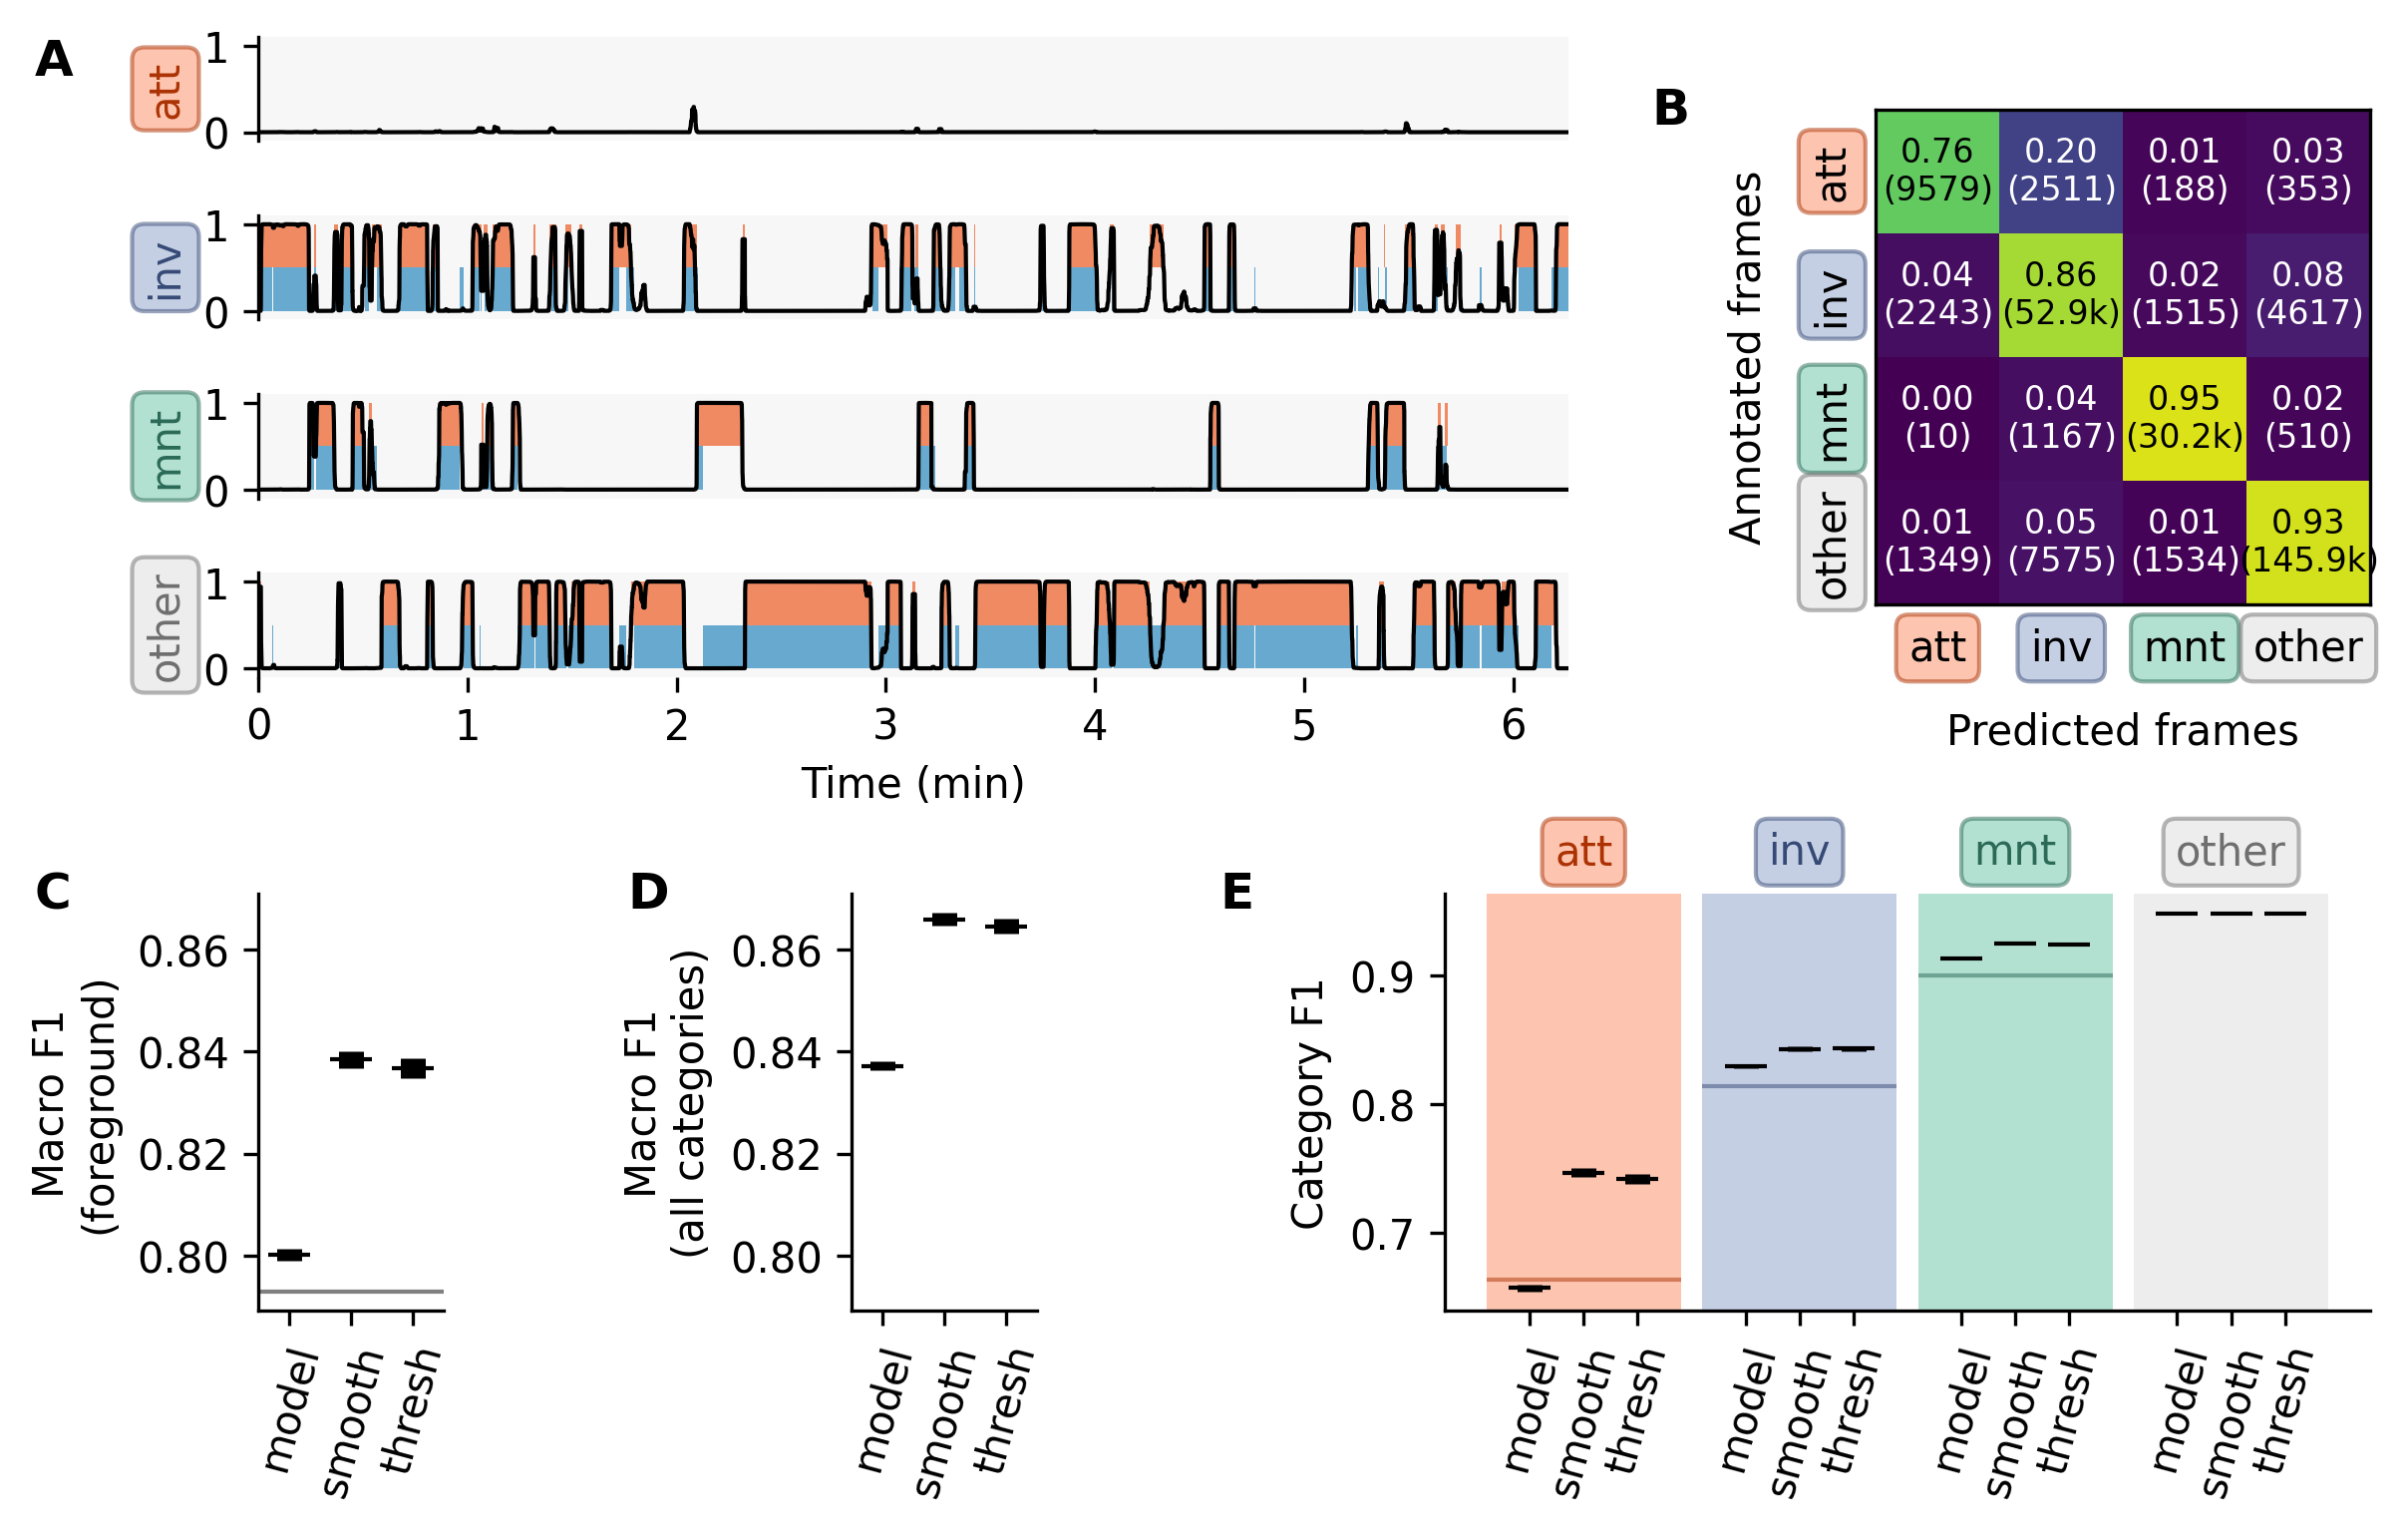

In [13]:
fig = plt.figure(layout="constrained", figsize=(8, 5), dpi=150)

gs = plt.GridSpec(5, 4, figure=fig, height_ratios=[1, 1, 1, 1, 4], width_ratios=[1.5, 1.5, 1, 4])

ax1 = fig.add_subplot(gs[-1, 0])
ax2 = fig.add_subplot(gs[-1, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[-1, 2:])

ax1.axhline(y=0.793, lw=1, c="grey")
means, stds = scores_timestamp[["step", "f1_macro_foreground"]].groupby("step").aggregate(("mean", "std")).to_numpy().T
ax1.errorbar(np.arange(means.size), means, stds, ls="none", marker="_", ms=10, lw=6, markeredgecolor="k", color="k")
ax1.set_xticks(np.arange(means.size))
ax1.set_xlim(-0.5, means.size - 0.5)
ax1.set_xticklabels(["model", "smooth", "thresh"], rotation=75)
ax1.set_ylabel("Macro F1\n(foreground)")

means, stds = scores_timestamp[["step", "f1_macro"]].groupby("step").aggregate(("mean", "std")).to_numpy().T
ax2.errorbar(np.arange(means.size), means, stds, ls="none", marker="_", ms=10, lw=6, markeredgecolor="k", color="k")
ax2.set_xticks(np.arange(means.size))
ax2.set_xlim(-0.5, means.size - 0.5)
ax2.set_xticklabels(["model", "smooth", "thresh"], rotation=75)
ax2.set_ylabel("Macro F1\n(all categories)")

for idx, step in enumerate(["model_outputs", "smoothing", "thresholding"]):
    means, stds = pd.melt(scores_timestamp.groupby("step").get_group(step).iloc[:, -4:], var_name="score").groupby("score").aggregate(("mean", "std")).to_numpy().T
    ax3.errorbar(np.arange(means.size) + idx / 4, means, stds, ls="none", marker="_", ms=10, lw=6, markeredgecolor="k", color="k")
ax3.set_xticks([x for x in range(4) for x in np.arange(x, x + 0.75, 0.25)])
ax3.set_xticklabels(["model", "smooth", "thresh"] * 4, rotation=75)
for (x, category), color, baseline in zip(enumerate(category_labels), colors, [0.664, 0.814, 0.900, None]):
    ax3.axvspan(x - 0.2, x + 0.7, color=color, alpha=0.5, lw=0)
    ax3.text(x + 0.25, 1.05, category, ha="center", va="bottom", color=adjust_lightness(color, 0.5),
             bbox=dict(boxstyle="round", ec=adjust_lightness(color, 0.5), fc=color, alpha=0.5),
             transform=transforms.blended_transform_factory(ax3.transData, ax3.transAxes))
    if baseline is not None:
        ax3.hlines(baseline, x - 0.2, x + 0.7, lw=1, alpha=0.5, color=adjust_lightness(color, 0.5), capstyle="butt")
ax3.set_ylabel("Category F1")

for ax in [ax1, ax2, ax3]:
    ax.spines[["right", "top"]].set_visible(False)


axes = [fig.add_subplot(gs[idx, :3]) for idx in range(len(category_labels))]

dyad_results = test_result.classification_results[18].classification_results[('resident', 'intruder')]
plot_classification_timeline(
    dyad_results.predictions,
    dyad_results.categories,
    annotations=dyad_results.annotations,
    timestamps=dyad_results.timestamps,
    y_proba_smoothed=dyad_results.y_proba_smoothed,
    interval=(-np.inf, np.inf),
    x_tick_step=30 * 60,
    x_tick_conversion=lambda ticks: (np.asarray(ticks) / (30 * 60)).astype(int),
    category_labels=category_labels,
    axes=axes,
)

for ax, color in zip(axes, colors):
    ax.set_ylabel(ax.get_ylabel(), color=adjust_lightness(color, 0.5), rotation=90,
                  va="bottom",
                  bbox=dict(boxstyle="round", ec=adjust_lightness(color, 0.5), fc=color, alpha=0.5))
ax.set_xlabel("Time (min)")

ax4 = fig.add_subplot(gs[:-1, 3])

plot_confusion_matrix(
    [y_true for y_true, _ in confusion_timestamp],
    [y_pred for _, y_pred in confusion_timestamp],
    ax=ax4,
    category_labels=category_labels,
    show_colorbar=False,
)
labels = []
for label, color in zip(ax4.get_xticklabels(), colors):
    label.set_bbox(dict(boxstyle="round", ec=adjust_lightness(color, 0.5), fc=color, alpha=0.5))
for label, color in zip(ax4.get_yticklabels(), colors):
    label.set_bbox(dict(boxstyle="round", ec=adjust_lightness(color, 0.5), fc=color, alpha=0.5))
ax4.tick_params(axis='both', which='major', pad=2, width=0)
ax4.set_ylabel("Annotated frames", labelpad=10)
ax4.set_xlabel("Predicted frames", labelpad=10)

fig.text(0, 1, "A", transform=(axes[0].transAxes + transforms.ScaledTranslation(-0.75, 0, fig.dpi_scale_trans)),
         fontsize=12, va='top', weight='semibold')
fig.text(0, 1, "B", transform=(ax4.transAxes + transforms.ScaledTranslation(-0.75, 0, fig.dpi_scale_trans)),
         fontsize=12, va='center', weight='semibold')
fig.text(0, 1, "C", transform=(ax1.transAxes + transforms.ScaledTranslation(-0.75, 0, fig.dpi_scale_trans)),
         fontsize=12, va='center', weight='semibold')
fig.text(0, 1, "D", transform=(ax2.transAxes + transforms.ScaledTranslation(-0.75, 0, fig.dpi_scale_trans)),
         fontsize=12, va='center', weight='semibold')
fig.text(0, 1, "E", transform=(ax3.transAxes + transforms.ScaledTranslation(-0.75, 0, fig.dpi_scale_trans)),
         fontsize=12, va='center', weight='semibold')

plt.show()

In [54]:
# # recreate the a-soid "predicted ethogram" subpanel
# # this is actually visualizing the concatenation of all video sequences in the test set
# # note that this is very hard to interpret. -> skip

# fig, ax = plt.subplots(figsize=(4, 3))

# plt.scatter(
#     np.arange(test_result.y_true_numeric[::50].size),
#     test_result.y_true_numeric[::50],
#     s=2, alpha=0.5, lw=0,
# )

# plt.scatter(
#     np.arange(test_result.y_true_numeric[::50].size),
#     test_result.y_pred_numeric[::50] + 0.1,
#     s=2, alpha=0.5, lw=0,
# )

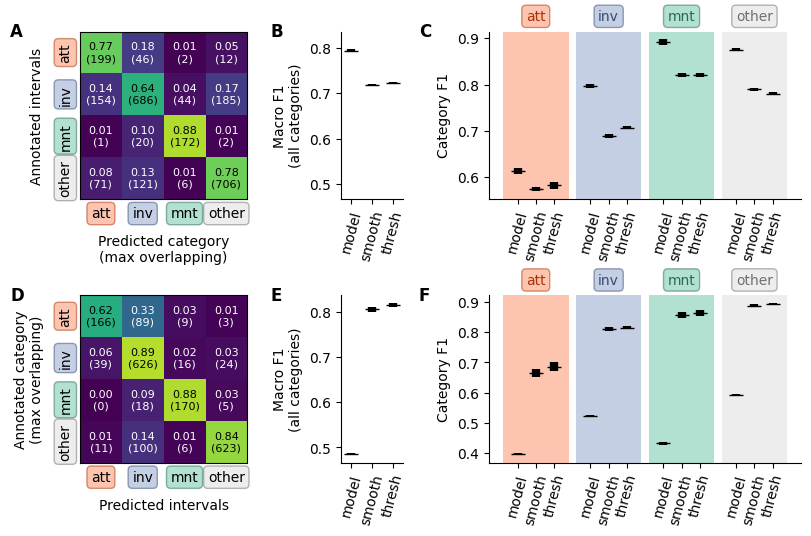

In [16]:
fig, axes = plt.subplots(2, 3, layout="constrained", figsize=(8, 5.25), dpi=50, width_ratios=[3, 1, 5])

plot_confusion_matrix(
    [y_true for y_true, _ in confusion_annotation],
    [y_pred for _, y_pred in confusion_annotation],
    ax=axes[0, 0],
    category_labels=category_labels,
    show_colorbar=False,
)
labels = []
for label, color in zip(axes[0, 0].get_xticklabels(), colors):
    label.set_bbox(dict(boxstyle="round", ec=adjust_lightness(color, 0.5), fc=color, alpha=0.5))
for label, color in zip(axes[0, 0].get_yticklabels(), colors):
    label.set_bbox(dict(boxstyle="round", ec=adjust_lightness(color, 0.5), fc=color, alpha=0.5))
axes[0, 0].tick_params(axis='both', which='major', pad=2, width=0)
axes[0, 0].set_ylabel("Annotated intervals", labelpad=10)
axes[0, 0].set_xlabel("Predicted category\n(max overlapping)", labelpad=10)

means, stds = scores_annotation[["step", "f1_macro"]].groupby("step").aggregate(("mean", "std")).to_numpy().T
axes[0, 1].errorbar(np.arange(means.size), means, stds, ls="none", marker="_", ms=10, lw=6, markeredgecolor="k", color="k")
axes[0, 1].set_xticks(np.arange(means.size))
axes[0, 1].set_xlim(-0.5, means.size - 0.5)
axes[0, 1].set_xticklabels(["model", "smooth", "thresh"], rotation=75)
axes[0, 1].set_ylabel("Macro F1\n(all categories)")

for idx, step in enumerate(["model_outputs", "smoothing", "thresholding"]):
    means, stds = pd.melt(scores_annotation.groupby("step").get_group(step).iloc[:, -4:], var_name="score").groupby("score").aggregate(("mean", "std")).to_numpy().T
    axes[0, 2].errorbar(np.arange(means.size) + idx / 4, means, stds, ls="none", marker="_", ms=10, lw=6, markeredgecolor="k", color="k")
axes[0, 2].set_xticks([x for x in range(4) for x in np.arange(x, x + 0.75, 0.25)])
axes[0, 2].set_xticklabels(["model", "smooth", "thresh"] * 4, rotation=75)
for (x, category), color in zip(enumerate(category_labels), colors):
    axes[0, 2].axvspan(x - 0.2, x + 0.7, color=color, alpha=0.5, lw=0)
    axes[0, 2].text(
        x + 0.25, 1.05, category, ha="center", va="bottom", color=adjust_lightness(color, 0.5),
        bbox=dict(boxstyle="round", ec=adjust_lightness(color, 0.5), fc=color, alpha=0.5),
        transform=transforms.blended_transform_factory(axes[0, 2].transData, axes[0, 2].transAxes),
    )
axes[0, 2].set_ylabel("Category F1")

plot_confusion_matrix(
    np.asarray([y_true for y_true, _ in confusion_prediction], dtype=object),
    np.asarray([y_pred for _, y_pred in confusion_prediction], dtype=object),
    ax=axes[1, 0],
    category_labels=category_labels,
    show_colorbar=False,
)
labels = []
for label, color in zip(axes[1, 0].get_xticklabels(), colors):
    label.set_bbox(dict(boxstyle="round", ec=adjust_lightness(color, 0.5), fc=color, alpha=0.5))
for label, color in zip(axes[1, 0].get_yticklabels(), colors):
    label.set_bbox(dict(boxstyle="round", ec=adjust_lightness(color, 0.5), fc=color, alpha=0.5))
axes[1, 0].tick_params(axis='both', which='major', pad=2, width=0)
axes[1, 0].set_ylabel("Annotated category\n(max overlapping)", labelpad=10)
axes[1, 0].set_xlabel("Predicted intervals", labelpad=10)

means, stds = scores_prediction[["step", "f1_macro"]].groupby("step").aggregate(("mean", "std")).to_numpy().T
axes[1, 1].errorbar(np.arange(means.size), means, stds, ls="none", marker="_", ms=10, lw=6, markeredgecolor="k", color="k")
axes[1, 1].set_xticks(np.arange(means.size))
axes[1, 1].set_xlim(-0.5, means.size - 0.5)
axes[1, 1].set_xticklabels(["model", "smooth", "thresh"], rotation=75)
axes[1, 1].set_ylabel("Macro F1\n(all categories)")

for idx, step in enumerate(["model_outputs", "smoothing", "thresholding"]):
    means, stds = pd.melt(scores_prediction.groupby("step").get_group(step).iloc[:, -4:], var_name="score").groupby("score").aggregate(("mean", "std")).to_numpy().T
    axes[1, 2].errorbar(np.arange(means.size) + idx / 4, means, stds, ls="none", marker="_", ms=10, lw=6, markeredgecolor="k", color="k")
axes[1, 2].set_xticks([x for x in range(4) for x in np.arange(x, x + 0.75, 0.25)])
axes[1, 2].set_xticklabels(["model", "smooth", "thresh"] * 4, rotation=75)
for (x, category), color in zip(enumerate(category_labels), colors):
    axes[1, 2].axvspan(x - 0.2, x + 0.7, color=color, alpha=0.5, lw=0)
    axes[1, 2].text(
        x + 0.25, 1.05, category, ha="center", va="bottom", color=adjust_lightness(color, 0.5),
        bbox=dict(boxstyle="round", ec=adjust_lightness(color, 0.5), fc=color, alpha=0.5),
        transform=transforms.blended_transform_factory(axes[1, 2].transData, axes[1, 2].transAxes),
    )
axes[1, 2].set_ylabel("Category F1")

for ax in [axes[0, 1], axes[0, 2], axes[1, 1], axes[1, 2]]:
    ax.spines[["right", "top"]].set_visible(False)

axes[0, 1].sharey(axes[1, 1])

for ax, label in zip(axes.ravel(), ["A", "B", "C", "D", "E", "F"]):
    ax.text(0, 1, label, transform=(ax.transAxes + transforms.ScaledTranslation(-0.7, 0, fig.dpi_scale_trans)),
            fontsize=12, va='center', weight='semibold')

fig.get_layout_engine().set(wspace=0.05)

In [217]:
pd.Series(extractor.feature_names).to_clipboard()

In [220]:
len(extractor.feature_names)

205

In [69]:
scores.drop(columns="iteration").groupby("step").aggregate(("mean", "std")).round(decimals=3).to_clipboard()

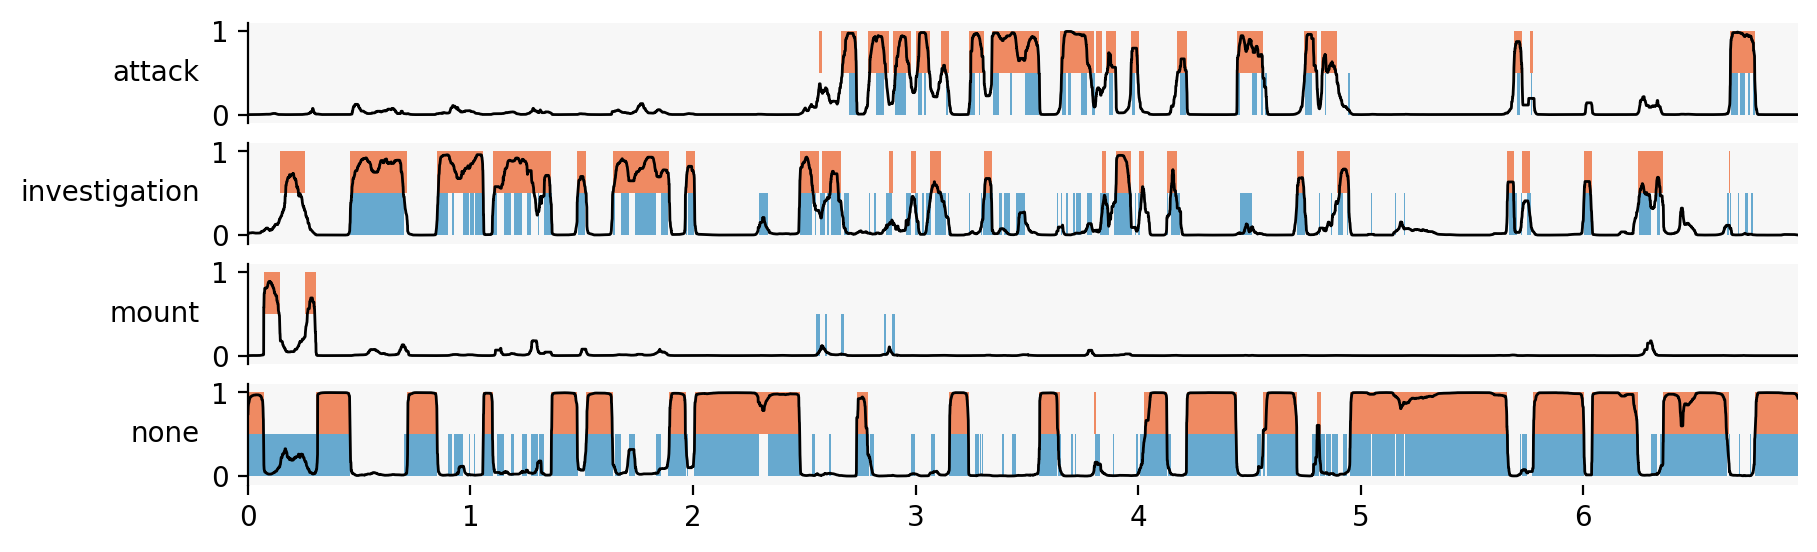

In [13]:
classification_results = k_fold_results[4].classification_results[69].classification_results[('resident', 'intruder')]

plot_classification_timeline(
    classification_results.predictions,
    classification_results.categories,
    annotations=classification_results.annotations,
    timestamps=classification_results.timestamps,
    interval=(-np.inf, np.inf),
    # y_proba=classification_results.y_proba,
    y_proba_smoothed=classification_results.y_proba_smoothed,
    x_tick_step=(60 * 30),
    x_tick_conversion=lambda ticks: [int(tick / (30 * 60)) for tick in ticks],
)

In [19]:
from sklearn.metrics import f1_score

scores = {}

default_decision = 3

for k_fold_result in tqdm(k_fold_results):
    categories = k_fold_result.categories
    y_true_numeric = k_fold_result.y_true_numeric
    y_proba = k_fold_result.y_proba_smoothed
    probability = y_proba.max(axis=1)

    for label in range(len(categories)):
        if label == default_decision:
            continue
        if label not in scores:
            scores[label] = []
        scores[label].append([])
        for threshold in np.linspace(0, 1, 101, endpoint=True):
            decision = np.argmax(y_proba, axis=1)
            decision[(decision == label) & (probability < threshold)] = default_decision
            scores[label][-1].append(f1_score(y_true_numeric == label, decision == label, zero_division=np.nan))
        scores[label][-1] = np.asarray(scores[label][-1])

for label in scores:
    scores[label] = np.asarray(scores[label])

  0%|          | 0/5 [00:00<?, ?it/s]

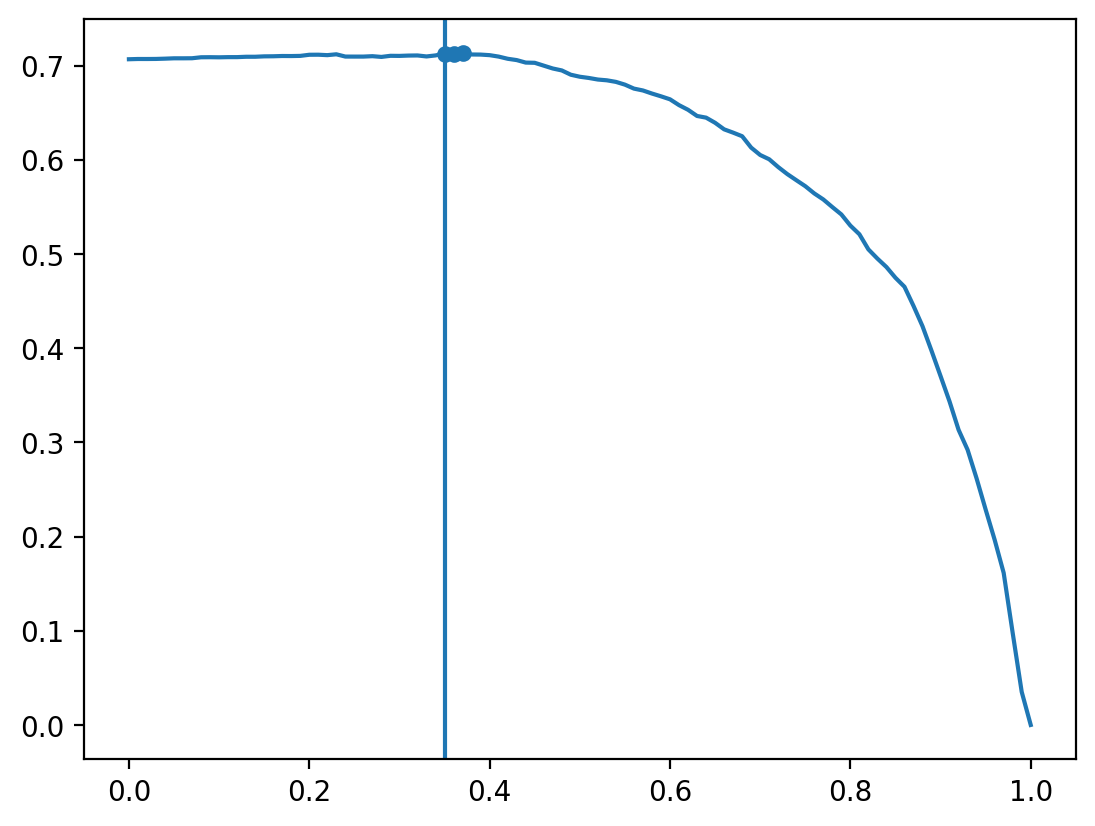

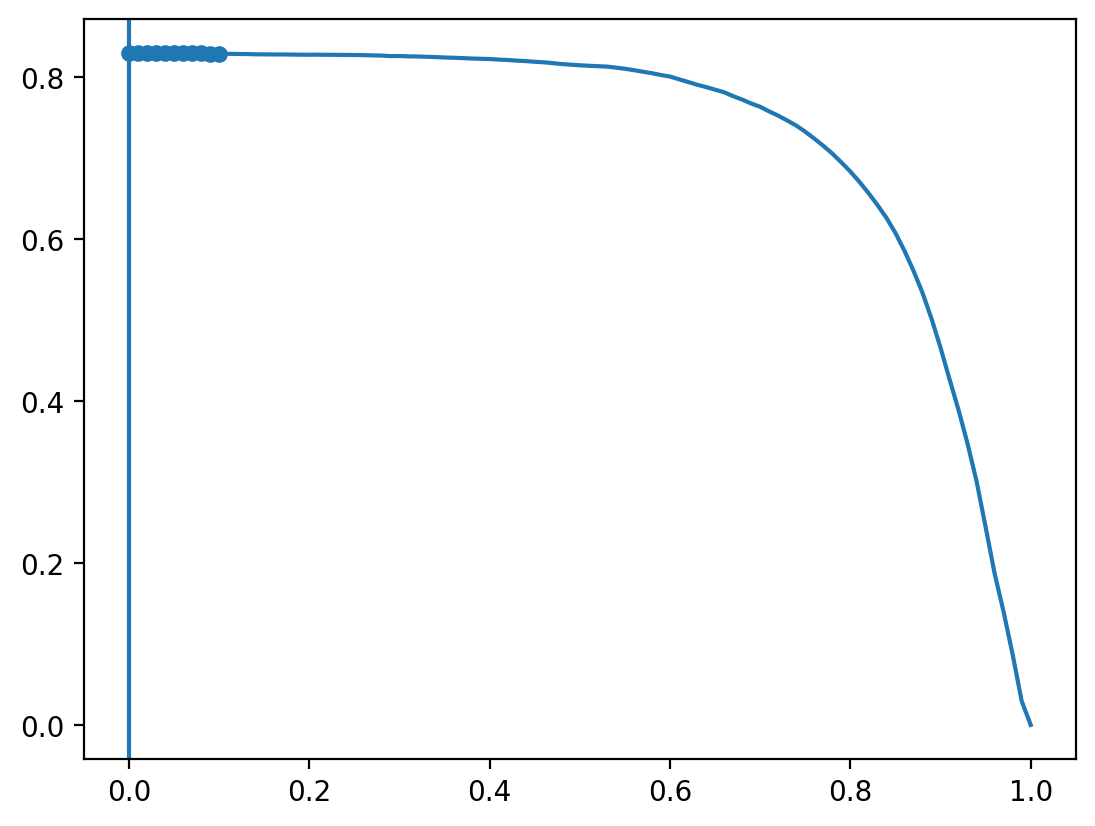

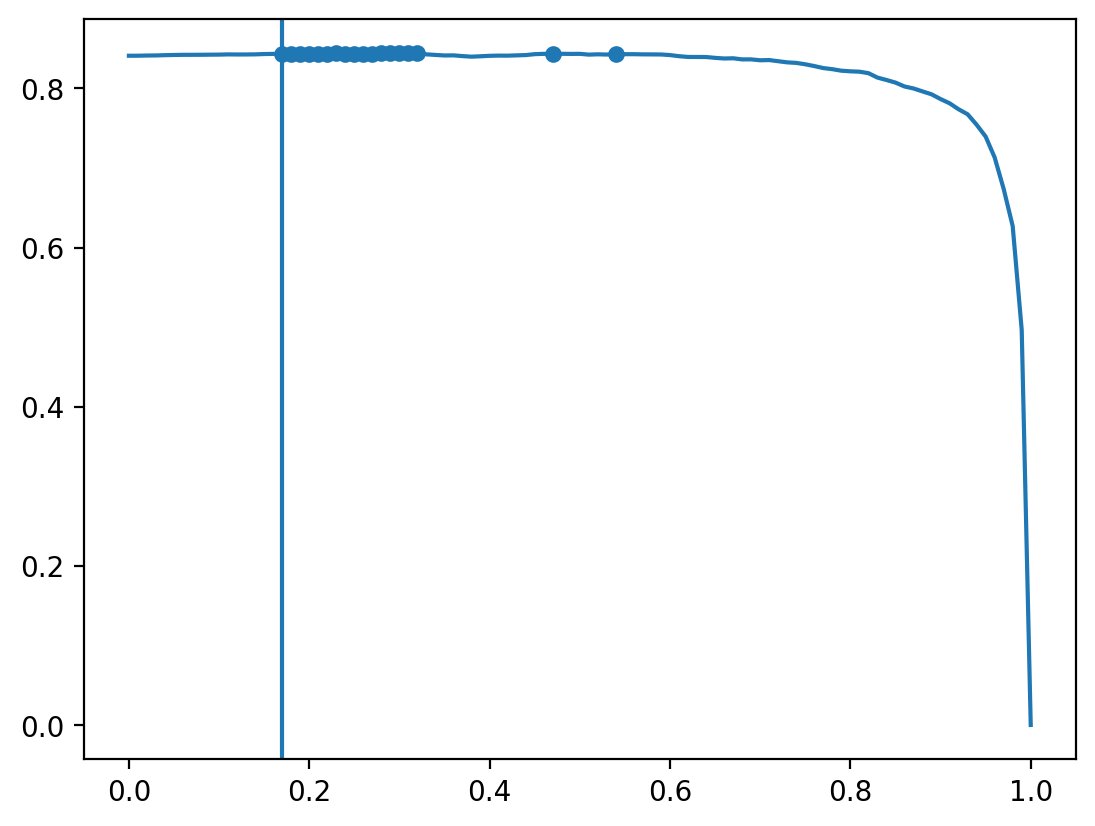

In [20]:
for label in scores:
    tolerance = 0.001

    avg_score = scores[label].mean(axis=0)
    best = np.argwhere(avg_score >= avg_score.max() - tolerance).ravel()

    plt.plot(np.linspace(0, 1, 101, endpoint=True), avg_score)
    plt.scatter(np.linspace(0, 1, 101, endpoint=True)[best], avg_score[best], lw=0)
    plt.axvline(np.linspace(0, 1, 101, endpoint=True)[best[0]])

    plt.show()

In [ ]:
from sklearn.metrics import f1_score

f1_score(
    dataset_train.encode(dataset_classification_result.predictions["true_category"].to_numpy()),
    dataset_train.encode(dataset_classification_result.predictions["category"].to_numpy()),
    labels=range(len(dataset_train.categories)),
    average=None,
)

In [ ]:
from sklearn.metrics import f1_score

f1_score(
    dataset_train.encode(dataset_classification_result.predictions["true_category"].to_numpy()),
    dataset_train.encode(dataset_classification_result.predictions["category"].to_numpy()),
    labels=range(len(dataset_train.categories)),
    average=None,
)

In [ ]:
from sklearn.metrics import f1_score

f1_score(
    dataset_train.encode(dataset_classification_result.predictions["true_category"].to_numpy()),
    dataset_train.encode(dataset_classification_result.predictions["category"].to_numpy()),
    labels=range(len(dataset_train.categories)),
    average=None,
)

In [ ]:
from classification_utils import validate_predictions, interval_f1_score

import matplotlib.pyplot as plt

plt.boxplot(
    [
        f1_scores[np.isfinite(f1_scores)]
        for f1_scores in
        interval_f1_score(
            dataset_classification_result.predictions,
            dataset_classification_result.annotations,
            encode_func=dataset_train.encode,
            num_categories=len(dataset_train.categories),
        ).T
    ]
)
plt.show()

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
y_test_numeric = dataset_train.encode(y_test)
y_pred = xgbc.predict(X_test)

plot_confusion_matrix(y_test_numeric, y_pred, category_labels=["att", "inv", "mnt", "none"])

In [ ]:
f1_score(y_test_numeric, y_pred, average=None)

In [ ]:
dataset_predictions_test = to_prediction_dataset(classification_result_dataset_test, target="dyads")

In [ ]:
save_dataset(dataset_predictions_test, directory="datasets", dataset_name="mice_predictions", annotation_type="predictions")

In [ ]:
from automated_scoring.io import load_dataset

dataset_predictions = load_dataset(directory="datasets", target="dyads", categories=('attack', 'investigation', 'mount', 'none'), dataset_name="mice_predictions", annotation_type="predictions")

In [ ]:
from observation_library import ObservationLibrary
from glob import glob
import json

annotations = dataset_predictions.get_annotations(exclude=[("intruder", "resident")])

video_files = sorted(glob("/home/paul/Downloads/task1_videos_mp4/test/*.mp4"))
video_lookup = {idx: [video_file] for idx, video_file in enumerate(video_files)}
trajectory_lookup = {
    group: dataset_predictions.select(group).trajectories
    for group in (
        dataset_predictions.groups
        if isinstance(dataset_predictions.groups, dict)
        else range(len(dataset_predictions.groups))
    )
}

observation_library = ObservationLibrary(
    annotations,
    video_lookup=video_lookup,
    trajectory_lookup=trajectory_lookup,
    num_keypoints=7,
    filter_dependencies={
        "actor": ("group", ),
        "recipient": ("group", "actor"),
    },
    highlight_observations_mode="category",
    selected_observations_mode="dyad",
)

with open("render_settings.json", "r") as f:
    render_settings = json.load(f)
    for key in render_settings:
        setattr(observation_library.render_settings, key, render_settings[key])

observation_library